In [30]:
using Integrals
using SpecialFunctions
using Base.Threads
using Glob
using DataFrames
using CSV
using CairoMakie
using LaTeXStrings
using Polynomials
using Statistics
using PhysicalConstants.CODATA2018
using FilePathsBase
using ColorSchemes
CairoMakie.activate!(inline=true)

In [31]:
CairoMakie.activate!(inline=true)
custom_theme = Theme(
    fontsize = 8,
    linewidth = 1.5,
    fonts = (; regular = "Helvetica"),
    Axis = (
        spinewidth = 1,
        xgridvisible = false,
        ygridvisible = false,
        topspinevisible = false,
        rightspinevisible = false,
        xtickwidth = 1,
        xticksize = 2,
        ytickwidth = 1,
        yticksize = 2,
    ),
    Colorbar = (
        spinewidth = 1,
        tickwidth = 1,
        ticksize = 2,
    ),
    Legend = (
        framevisible = false,
    )
)
set_theme!(custom_theme)

In [32]:
using Unitful
Unitful.preferunits(u"nm")

In [33]:
Unitful.register(@__MODULE__);
@unit b "b" b (0.34)*(45/(45+146))*u"nm" false
@unit kb "kb" kb 1000*u"b" false

┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GY

kb

In [34]:
# Diffusivity of protein
Dc = 1.0u"μm^2/s"
# Partition ratio c+/c-
Pc = 5
# Diffusivity of RNA
Dm = 0.03u"μm^2/s" 
# Radius of droplet
R = 250 * u"nm"
# Nascent RNA lifetime
lifetime_RNA = uconvert(u"s",10u"minute")
kd = 1/(lifetime_RNA)
# RNA diffusion length
l = sqrt(Dm/kd)
# Contour length of DNA
Lc = uconvert(u"nm",200u"kb")
# Kuhn length of DNA
LK = 35.36u"nm"
# Root mean squared end-to-end vector
rmsd = sqrt(Lc*LK)
# Persistence length of DNA
Lp = LK/2
# Diffusivity of DNA
Dapp = 0.01u"μm^2/s^(1/2)"
De = uconvert(u"μm^2/s",(Dapp/((12/pi)^(1/2)*LK))^2)
# Alpha parameter for DNA
getα(Lc) = 3/(4*Lp*Lc)
getLc(α) = 3/(4*Lp*α)
α = upreferred(getα(Lc))
# Temperature
T = (37 + 273.15)u"K"
# kBT
kBT = BoltzmannConstant*T
# Beta
function getβperkBT(X); return - 3/2 * 1/(Dm*De) * 1/(Pc -1) * l/(4/3*pi*R^3) * X*u"μm^5*s^(-2)"; end
# Production rate
kp = 1u"s^(-1)"

┌ Warning: Symbol kb was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715


1 s⁻¹

In [35]:
function velocity3d(z0,R,l)
    function f(u,p)
        x = u[1]
        z0 = p[1]; R = p[2]; l = p[3]
        return x*R^2*exp(-sqrt(R^2+z0^2-2*R*x*z0)/l)/sqrt(R^2+z0^2-2*R*x*z0)
    end
    domain = ([-1], [1])
    p = (z0, R, l)
    prob = IntegralProblem(f, domain, p)
    sol = solve(prob, QuadGKJL(), reltol = 1e-12, abstol = 1e-12)
    velocity = sol.u
    return velocity
end

velocity3d (generic function with 1 method)

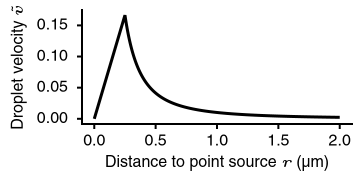

In [36]:
cm = 28.3465
golden = 1.618
fig = Figure(size = (8.5*1.5cm*0.5, 8.5*1.5cm*0.25),background_color=:transparent, figure_padding=5,
backgroundcolor = :transparent)
ax1 = Axis(fig[1, 1],xlabel=rich("Distance to point source ",rich("r",font="italic")," (μm)"),ylabel=rich("Droplet velocity ",rich("ṽ",font="italic")), backgroundcolor = :transparent)
x = 0:0.001:2
lines!(ax1, x, velocity3d.(x,ustrip(u"μm",R),ustrip(u"μm",l)),color="black")
save("./figures/3dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent,dpi=600)
fig